In [1]:
import numpy as np
from scipy.sparse import rand as sprand
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [121]:
# Make up some random explicit feedback ratings
# and convert to a numpy array
n_users = 1_00
n_items = 1_00
seed = 1234
n_epochs = 100
bs = 1 # Batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rng = np.random.default_rng(seed=seed)
ratings = sprand(n_users, n_items, density=0.01, format="csr")
ratings.data = rng.integers(1, 5, size=ratings.nnz).astype(np.float64)
ratings = ratings.toarray()

In [122]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=False)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=False)

    def forward(self, user, item):
        return torch.matmul(self.user_factors(user), torch.t(self.item_factors(item)))
    
model = MatrixFactorization(n_users, n_items, n_factors=20).to(device)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)  # learning rate

In [123]:
loss_curve = []
for ep in range(n_epochs):
 
    nz_idxs = torch.t(torch.LongTensor(ratings.nonzero()))
    dl = DataLoader(nz_idxs, batch_size=bs)
    epoch_loss = []
    for i, batch in enumerate(dl):
        # Set gradients to zero
        optimizer.zero_grad()
        
        row, col = batch[:,0], batch[:,1]

        target = ratings[*torch.meshgrid(row, col, indexing='xy')]
        if bs == 1:
            target = np.array([target]).reshape(1,1)

        target = torch.FloatTensor(target).to(device)

        # Predict and calculate loss
        prediction = model(row, col)
        loss = loss_func(prediction, target)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        epoch_loss.append(loss.item())

    epoch_loss = np.array(epoch_loss)
    loss_curve.append((epoch_loss.mean(), epoch_loss.std()))

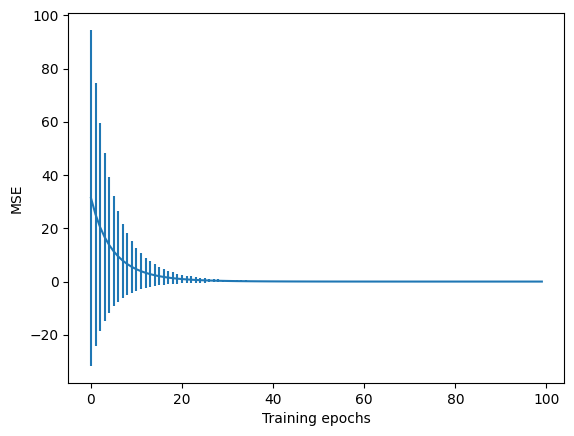

In [124]:
ave_loss, std_loss = list(zip(*loss_curve))

plt.errorbar(x=np.arange(n_epochs), y=ave_loss, yerr=std_loss)
plt.xlabel('Training epochs')
plt.ylabel('MSE')
plt.show()

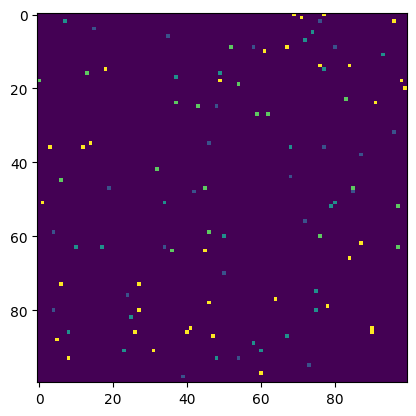

In [118]:
plt.imshow(ratings)

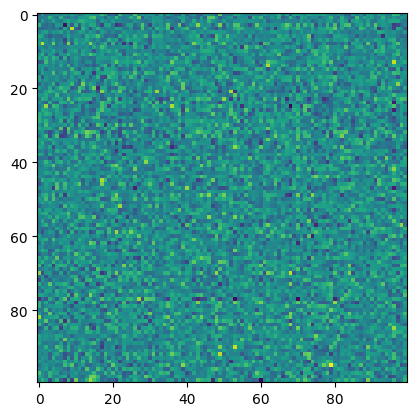

In [119]:
all_users = torch.LongTensor(np.arange(n_users))
all_items = torch.LongTensor(np.arange(n_items))

y_pred = model(all_users, all_items).detach().numpy()

plt.imshow(y_pred)

In [8]:
# rows = np.array([48, 98])
# cols = np.array([45, 69])

# trows = torch.LongTensor(rows)
# tcols = torch.LongTensor(cols)
# y_pred = model(trows, tcols)
# y = ratings[*np.meshgrid(rows, cols)]
# y_pred, y

(tensor([[ 1.8076, -5.4739],
         [-0.3544, -8.4870]], grad_fn=<MmBackward0>),
 array([[0., 0.],
        [0., 0.]]))

In [129]:
torch.LongTensor(np.array(ratings.nonzero())).shape

torch.Size([2, 100])